# Definition


---


VaR is a bound or quantile that defines the loss of the portfolio at a certain date T is not exceeding $1-\alpha$, i.e. the loss can exceed the bound with probability $\alpha$.
If $\alpha$ is 0.01, it can be seen as:
1. there is the 99% of chance that the loss is not higher than the VaR;
2. there is the 1% of probability that the loss is higher than the VaR.

Basically, the focus in VaR is clearly on downside risk and potential losses.

In addition it is negative when we look at profit&loss representation, but positive when we look at loss&profit representation.

For the value risk we need to specify:
1. the quantile given by $\alpha $;
2. the time period (daily VaR, monthly ..);
3. the probability distribution of the risk.

*VaR is generally higher at longer time horizons and higher
confidence levels, but generally it is also less accurate!*
Remember that the narrower is the set of the "prediction", the better is the estimation!

# How can we calculate it?


---


We can compute the VaR in three main ways:
1. **historical simulation**: we start with some data, then we sort them and we find the empirical distribution. We pick the changes in the
portfolio over time and they yield all the information you need to compute the Value at Risk. Once we have the distribution, we can calculate the **quantile** at a specified confidence level and this represents our possible loss.
There are some drawbacks:

    1.1) rely on historical weight;

    1.2) the data have the same weight even though each period can have a different trend in variability, so basically we are treating in a symmetric way something that is not symmetric.
    
    We underestimate the VaR. An adjustment can be reweight the recent past because they are better predictors of the immediate future than the ones distant in time.
    
    Hull and White suggest a different way of updating historical data for changes in volatility. **For assets where the recent volatility is higher than historical volatility, they recommend that the historical data be adjusted**;

    1.3) we could have no historic data on which we can perform it.

2. **parametric way**: it is based on the calculation on $\text VAR_\alpha= \mu - \text z_{\alpha} * \sigma $. Unfortunately, this relies on the normality distribution assumption (asymptotic normality) and the returns are not always normally distributed.

  There is the *leverage effect* that we need to consider and the distribution is skewed on the left (instead the main feature of the normal distribution is being symmetric).

  And then we need to model the conditional volatility parameter, maybe by using the GARCH model.
  
  In addition we assume that the data are iid, but actually they are not iid and it ignores the non-linearity of some returns (like in the options).
  This may lead to underestimation of the loss since non-linear instruments are more affected by the movements in the market (like the high volatility could affect in a huge way the options!)

3. **Monte carlo methods**: here we need to specify a **probability distributions** for each of the market risk factors. Once the distributions are specified, the simulation process starts. In each run, we have a different outcome and this is included in our portfolio. After a repeated series of runs, numbering usually you will have a distribution of portfolio values that can be used to assess Value at Risk by using the quantile chosen above.
We focus on Monte Carlo method below.

## Empirical way

With the empirical way we rely on the historical data without assume any distribution, so it is a good method but in some cases relyon only on the historical data is not always an accurate approach.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from numpy.random import lognormal
from scipy.stats import norm

In [2]:
TSLA= yf.download("TSLA", period="1y")
TSLA

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2024-02-05,181.059998,184.679993,175.009995,184.259995,134294400
2024-02-06,185.100006,186.490005,177.110001,177.210007,122676000
2024-02-07,187.580002,189.789993,182.679993,188.179993,111535200
2024-02-08,189.559998,191.619995,185.580002,189.000000,83034000
2024-02-09,193.570007,194.119995,189.479996,190.179993,84476300
...,...,...,...,...,...
2025-01-28,398.089996,400.589996,386.500000,396.910004,48910700
2025-01-29,389.100006,398.589996,384.480011,395.209991,68033600


[*********************100%***********************]  1 of 1 completed


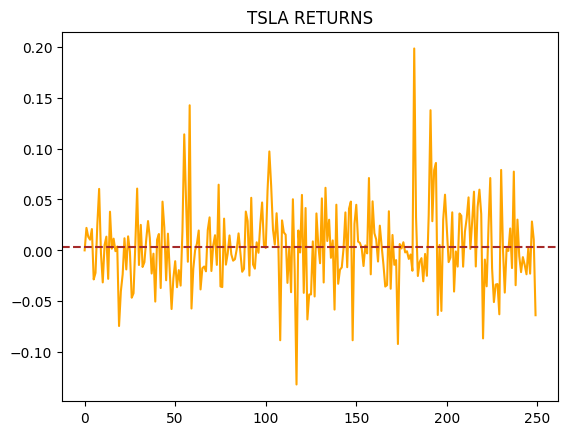

In [3]:
TSLA= yf.download("TSLA", period="1y")
TSLA = TSLA.reset_index()
TSLA["log_returns"] = np.log(TSLA['Close'] / TSLA['Close'].shift(1)).fillna(0)
TSLA["log_returns"].mean()
plt.plot(TSLA["log_returns"], color="orange")
plt.title("TSLA RETURNS")
plt.axhline(y=TSLA["log_returns"].mean(), linestyle="--", color="brown")
plt.show()

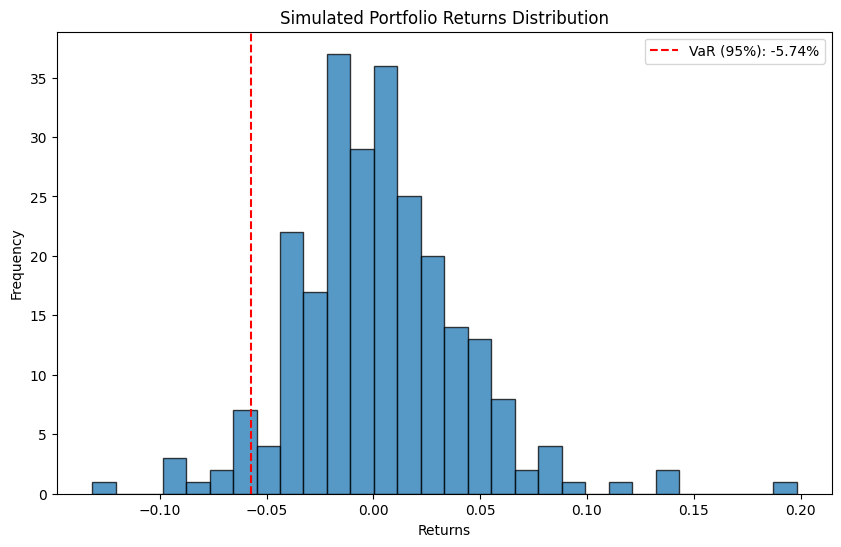

The portfolio loss is 573.6144178157805


In [4]:
TSLA["log_returns"]=TSLA["log_returns"].sort_values()
initial_investment= 10000
confidence_level=0.95
Var_empirical= np.percentile(TSLA["log_returns"], (1-confidence_level)*100)
plt.figure(figsize=(10, 6))
plt.hist(TSLA["log_returns"], bins=30, alpha=0.75, edgecolor="black")
plt.axvline(Var_empirical, color='red', linestyle='--', label=f'VaR (95%): {Var_empirical:.2%}')
plt.title('Simulated Portfolio Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()
portfolio_loss= initial_investment * abs(Var_empirical)
print(f"The portfolio loss is {portfolio_loss}")

## Parametric way
For the parametric method we need:
1. the mean of the returns;
2. the variance-covariance matrix (in this case we have one asset, so we are not going to perform it, but obviously if we have a portfolio with several assets and weights, it is necessary!)
3. we apply the ```norm.ppf``` that is the way to extract the quantile function and get the so-called z_score in the specified confidence level.
4. we apply the formula $\mu - z_{score}* std$ and we get the VaR.





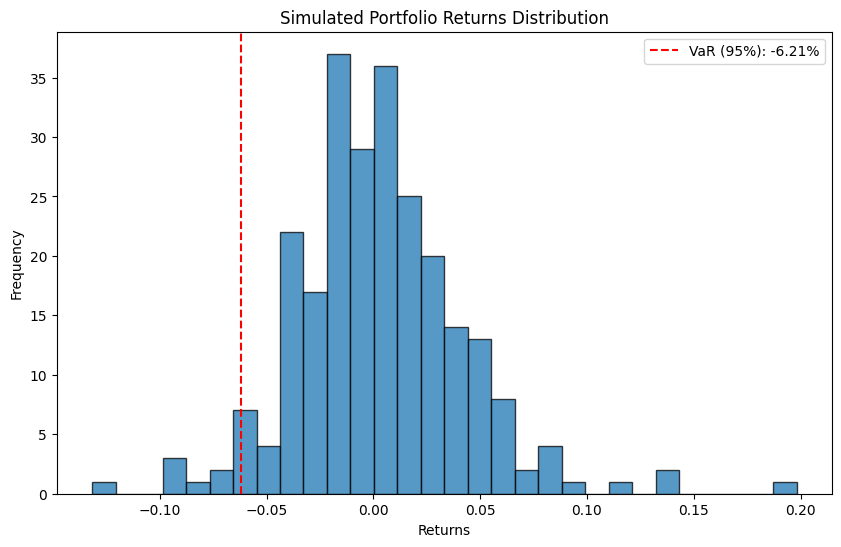

In [5]:
mean2=TSLA["log_returns"].mean()
std2= TSLA["log_returns"].std()
VaR_parametric= mean2-norm.ppf(confidence_level)*std2
plt.figure(figsize=(10, 6))
plt.hist(TSLA["log_returns"], bins=30, alpha=0.75, edgecolor="black")
plt.axvline(VaR_parametric, color='red', linestyle='--', label=f'VaR (95%): {VaR_parametric:.2%}')
plt.title('Simulated Portfolio Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()




## Monte Carlo methods
Basically, there are different advantages using it:
1. we can specify whichever distribution we want in order to compute it;
2. we do not rely on past values, but we are free to simulate and to get a good accuracy on the forecasted data.


In [6]:
#monte Carlo simulations
num_simulations = 10000
simulation_horizon = 252
simulation = np.random.normal(np.mean(TSLA["log_returns"]), np.std(TSLA["log_returns"]),(simulation_horizon, num_simulations))


Monte Carlo VaR (95% confidence level): -6.20%


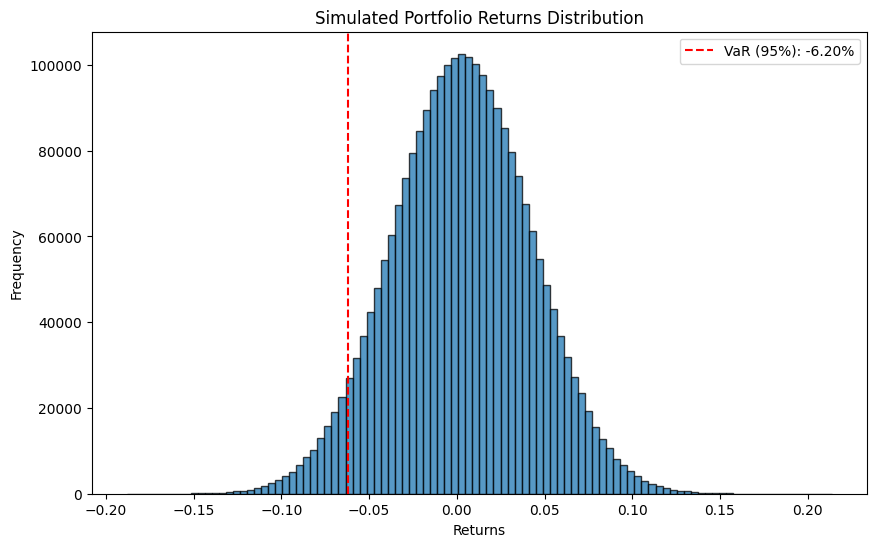

In [7]:
confidence_level = 0.95
VaR_monte_carlo = np.percentile(simulation, (1-confidence_level)*100)

print(f"Monte Carlo VaR (95% confidence level): {VaR_monte_carlo:.2%}")
plt.figure(figsize=(10, 6))
plt.hist(simulation.flatten(), bins=100, alpha=0.75, edgecolor="black")
plt.axvline(VaR_monte_carlo, color='red', linestyle='--', label=f'VaR (95%): {VaR_monte_carlo:.2%}')
plt.title('Simulated Portfolio Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [8]:
portfolio_loss = initial_investment * abs(VaR_monte_carlo)
portfolio_loss

619.8506263557001

# Expected shortfall


---


A risk measure should have:
1. **monotonicity**, since a portfolio that has low returns in which ever the state of the world, it must have a higher risk. It is called stochastic dominance;
2. **translation invariance**: it means that if we add a risk free asset, the asset reduces the portfolio's risk;
3. **homogeneity** because scaling the portfolio with a value $\lambda$ scales also the risk by $\lambda$;
4. **sub additivity** because the risk of two merged portfolio must be not greater than the sum of two single risk. It is related to the fact that diversification helps to reduce the overall risk.
VaR has the three properties, but unfortunately it does not have the sub-addivitivity because:
  - it may not diversify a lot the investments;
  - it is a linear instrument assumin a linear relationship between the individual risk and the portfolio's risk;
  - In addition, it looks at the possible loss, but it does not take into account what happens after the tail, in the case of extreme events!

So,another measure of the portfolio losses was introduced and that is the **expected shortfall**.
The expected shortfall is the $E(Losses \mid y < -Var_\alpha)$.

It provides a fully measure of what happens after the tail and it is a coherent measure.
Unfortunately this measure depends on which distribution we have chosen because it depends on the tail!

95% CVaR/ES is : -7.85%


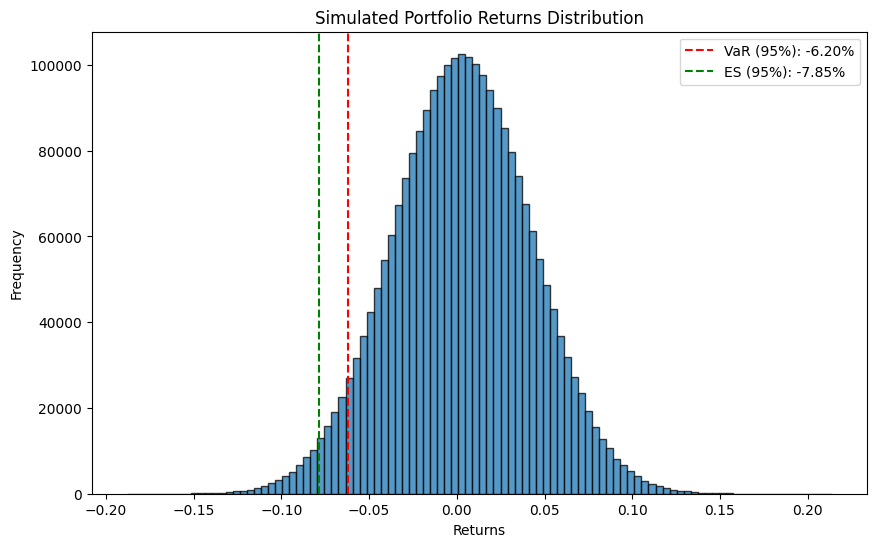

784.5952148775691

In [9]:
y=simulation.flatten()[simulation.flatten() < VaR_monte_carlo]
ES=np.mean(y)

print(f'95% CVaR/ES is : {ES:.2%}')
plt.figure(figsize=(10, 6))
plt.hist(simulation.flatten(), bins=100, alpha=0.75, edgecolor='black')
plt.axvline(VaR_monte_carlo, color='red', linestyle='--', label=f'VaR (95%): {VaR_monte_carlo:.2%}')
plt.axvline(ES, color='green', linestyle='--', label=f'ES (95%): {ES:.2%}')
plt.title('Simulated Portfolio Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

portfolio_loss = initial_investment * abs(ES)
portfolio_loss

Based on the analysis, the 95% VaR for the portfolio is 6.20%, meaning there is a 5% probability of experiencing a loss greater than 6.20% in a given period. However, looking beyond this threshold, the Expected Shortfall  is 7.85%, indicating that when losses exceed VaR, the average loss is significantly higher. This highlights the importance of considering tail risk when managing the portfolio’s downside exposure and it gives more and important information on the possible losses.